In [1]:
import numpy as np
import PIL as pil
import matplotlib.pyplot as plt
%matplotlib inline
#import cv2
import scipy
import scipy.misc
import scipy.signal
import warnings
import os
import re
import copy
warnings.filterwarnings("ignore", category=DeprecationWarning) 
#plt.rcParams['figure.figsize'] = (50,50)
plt.rcParams['image.cmap'] = 'gray'
import mrc as mrc
import version1 as v1
import version2 as v2
import version3 as v3
import version4 as v4

In [ ]:
%%time
#Copied over
#Second version of a code that takes image, stack and max_num a computer can work with and produce EK
#Adding functionality for larger template stacks and division errors
def Error_Particle(I, T, max_num):
    I = mrc.readMRC(I)
    T = mrc.readMRC(T)
    Error_Stack = Error_Template(I, T, max_num)
    Particle_Error = -scipy.misc.logsumexp(-Error_Stack, axis=2)
    print('############################')
    return(Particle_Error)
    
def Error_Template(I, T, max_num):
    I = I[:,:,0]
    x, y, z = T.shape
    h, l = I.shape
    
    xcent = int(h/2-x/2)
    ycent = int(l/2-y/2)
    
    padding = np.zeros_like(I)
    padding[xcent:xcent+int(x), ycent:ycent+int(y)] = 1.0
    
    f1 = np.fft.rfft2(I)
    f2 = np.fft.rfft2(padding)
    
    mask = np.zeros_like(I)
    
    EK = Template_Splitting(I,T, x, y, z, xcent, ycent,h,l,f1, f2, padding, mask, max_num)
    print(np.isfortran(EK))
    return(EK)
    
def Template_Splitting(I, T, x, y, z, xcent, ycent, h, l, f1, f2, padding, mask, max_num, start = 0):
    
    bins = z//max_num
    
    if bins > max_num:
        indices = np.linspace(0,z,max_num+1, dtype = int)
        total_stack = np.empty([h,l,max_num])
        
        for nn in range(max_num):
            slicet = T[:,:,indices[nn]:indices[nn+1]]
            height = slicet.shape[2]

            pp = Template_Splitting(I, slicet, x, y, height, xcent, ycent, h, l ,f1, f2, padding, mask, max_num)
            total_stack[:,:,nn] = -scipy.misc.logsumexp(-pp, axis=2)
        return total_stack
                   
    else:
        
        index = np.arange(start,z,max_num)
        inx_len = len(index)
        ek_stack = np.empty([h, l, inx_len])
        
        ejk_stack = np.empty([h, l, max_num])
        
        for nn in range(inx_len):
            try:
                zed = T[:,:,index[nn]:index[nn+1]]
                
            except IndexError:
                zed = T[:,:,index[nn]:]
                ejk_stack = np.empty([h,l,z-index[nn]])      
            
            for xx in range(zed.shape[2]):
                print('heythere')
                
                
                temp = zed[:,:,xx]
                temp = temp-np.mean(temp)
                
                mask[xcent:xcent+int(x), ycent:ycent+int(y)] = temp[::-1,::-1]
                
                crossc = fast_convolve(I, mask, IFT=f1)
                img_norm = fast_convolve(I**2, padding, PFT = f2)
                temp_norm = np.sum(temp**2)        
                
                ejk_stack[:,:,xx] = (img_norm + temp_norm - 2*crossc)
            
            ek_stack[:,:,nn] = -scipy.misc.logsumexp(-ejk_stack, axis=2)
            
            print('looping')
        
        return ek_stack
                       
    
def fast_convolve(I, T, IFT = 0, PFT = 0):   
    if np.any(IFT):
        
        f2 = np.fft.rfft2(T)
        conv = IFT*f2
        fc = np.fft.fftshift(np.fft.irfft2(conv))
    elif np.any(PFT):
            
        f1 = np.fft.rfft2(I)
            
        conv = f1*PFT
        fc = np.fft.fftshift(np.fft.irfft2(conv))
    else:
        f1 = np.fft.rfft2(I)
        f2 = np.fft.rfft2(T)

        conv = f1*f2
        fc = np.fft.fftshift(np.fft.irfft2(conv)) 
   
    return fc    
    
    
EKTEST1 = Error_Particle('imgdata_52006_1.mrc','imgdata_26005_particle_stack.mrc',15)

In [ ]:
%%time
#Copied over
#Third version of a code that takes image, stack and max_num a computer can work with and produce EK
#Adding functionality for larger template stacks and division errors
#Changing the ordering of the array to conform to C ordering for efficiency
def Error_Particle(I, T, max_num):
    I = mrc.readMRC(I)
    T = mrc.readMRC(T)
    T = np.ascontiguousarray(T)
    Error_Stack = Error_Template(I, T, max_num)
    Particle_Error = -scipy.misc.logsumexp(-Error_Stack, axis=0)
    #print('############################')
    return(Particle_Error)
    
def Error_Template(I, T, max_num):
    I = I[:,:,0]
    x, y, z = T.shape
    h, l = I.shape
    
    xcent = int(h/2-x/2)
    ycent = int(l/2-y/2)
    
    padding = np.zeros_like(I)
    padding[xcent:xcent+int(x), ycent:ycent+int(y)] = 1.0
    
    f1 = np.fft.rfft2(I)
    f2 = np.fft.rfft2(padding)
    
    mask = np.zeros_like(I)
    
    EK = Template_Splitting(I,T, x, y, z, xcent, ycent,h,l,f1, f2, padding, mask, max_num)
    
    return(EK)
    
def Template_Splitting(I, T, x, y, z, xcent, ycent, h, l, f1, f2, padding, mask, max_num, start = 0):
    
    bins = z//max_num
    
    if bins > max_num:
        indices = np.linspace(0,z,max_num+1, dtype = int)
        total_stack = np.empty([max_num, h, l])
        
        for nn in range(max_num):
            slicet = T[:,:,indices[nn]:indices[nn+1]]
            height = slicet.shape[2]

            pp = Template_Splitting(I, slicet, x, y, height, xcent, ycent, h, l ,f1, f2, padding, mask, max_num)
            total_stack[nn,:,:] = -scipy.misc.logsumexp(-pp, axis=0)
        return total_stack
                   
    else:
        
        index = np.arange(start,z,max_num)
        inx_len = len(index)
        ek_stack = np.empty([inx_len, h, l])
        
        
        ejk_stack = np.empty([max_num,h, l])
        
        
        for nn in range(inx_len):
            try:
                zed = T[:,:,index[nn]:index[nn+1]]
                
            except IndexError:
                zed = T[:,:,index[nn]:]
                ejk_stack = np.empty([z-index[nn],h,l])      
            
            for xx in range(zed.shape[2]):
                #print('heythere')
                
                
                temp = zed[:,:,xx]
                temp = temp-np.mean(temp)
                
                mask[xcent:xcent+int(x), ycent:ycent+int(y)] = temp[::-1,::-1]
                
                crossc = fast_convolve(I, mask, IFT=f1)
                img_norm = fast_convolve(I**2, padding, PFT = f2)
                temp_norm = np.sum(temp**2)        
                
                ejk_stack[xx,:,:] = (img_norm + temp_norm - 2*crossc)
                
            
            ek_stack[nn,:,:] = -scipy.misc.logsumexp(-ejk_stack, axis=0)
           
            
            #print('looping')
        
        return ek_stack
                       
    
def fast_convolve(I, T, IFT = 0, PFT = 0):   
    if np.any(IFT):
        
        f2 = np.fft.rfft2(T)
        conv = IFT*f2
        fc = np.fft.fftshift(np.fft.irfft2(conv))
    elif np.any(PFT):
            
        f1 = np.fft.rfft2(I)
            
        conv = f1*PFT
        fc = np.fft.fftshift(np.fft.irfft2(conv))
    else:
        f1 = np.fft.rfft2(I)
        f2 = np.fft.rfft2(T)

        conv = f1*f2
        fc = np.fft.fftshift(np.fft.irfft2(conv)) 
   
    return fc    
    
    
EKTEST2 = Error_Particle('imgdata_52006_1.mrc','imgdata_26005_particle_stack.mrc',15)

In [88]:
%%time
#Version 1 - Taking in a folder with stacks of a particle in different configurations and producing probabilities
#Method 1 assumes the prior are all equal, and methos 2 assumes not and combines into exp
#Method 1: -log(p(s_k|I)) = -logsumexp(-e_jk) + logsumexp(-e_k)
#Method 2: -log(p(s_k|I)) = -log(p(s_k)) - logsumexp(-e_jk) + logsumexp(log(p(s_k))-E_k)

def Config_Prob(I, folder, max_num = 10, method = 1, psk = []):
    I = mrc.readMRC(I)
    I = I[:,:,0]
    h , l = I.shape
    
    num_configs = len([name for name in os.listdir(folder) if os.path.isfile(os.path.join(folder, name)) and name[0] != '.'])
   
    
    ek_stack = np.empty([num_configs, h, l])
    prob_stack = np.empty([num_configs, h, l])
    
    padding = np.zeros_like(I)
    mask = np.zeros_like(I)
    
    f1 = np.fft.rfft2(I)
    
    if method == 1:
        count = 0
        
        for temp_stack in os.listdir(folder):
            
            T = mrc.readMRC(os.path.join(folder, temp_stack))
            T = np.ascontiguousarray(T)

            error_stack = Error_Template(I,T, max_num, f1, padding, mask, h, l)
            config_error = -scipy.misc.logsumexp(-error_stack, axis=0)
            
            ek_stack[count,:,:] = config_error
            count += 1 
            print('innerloop')
            
        ek_sum = scipy.misc.logsumexp(-ek_stack, axis = 0)
        
        
        for temp_stack in range(len(os.listdir(folder))):
            
            neg_prob = ek_stack[temp_stack,:,:] + ek_sum 
            prob_stack[temp_stack,:,:] = neg_prob
            
        return prob_stack
    
        
    
    else:
        count = 0
        
        for temp_stack in os.listdir(folder):
            
            T = mrc.readMRC(os.path.join(folder, temp_stack))
            T = np.ascontiguousarray(T)

            error_stack = Error_Template(I,T, max_num, f1, padding, mask, h, l)
            config_error = -scipy.misc.logsumexp(-error_stack, axis=0)
            
            ek_stack[count,:,:] = config_error
            count += 1 
            
            print('innerloop')
            
        for temp_stack in range(len(os.listdir(folder))):
            
            ek_sum = scipy.misc.logsumexp((np.log(psk[temp_stack])-ek_stack),axis = 0)
            
            neg_prob = -np.log(psk[temp_stack]) + ek_stack[temp_stack,:,:] + ek_sum
            prob_stack[temp_stack,:,:] = neg_prob
        
        return prob_stack
        
        
        
def Error_Template(I, T, max_num, f1, padding, mask, h, l):
    x, y, z = T.shape
    
    xcent = int(h/2-x/2)
    ycent = int(l/2-y/2)
    
    padding[xcent:xcent+int(x), ycent:ycent+int(y)] = 1.0
    f2 = np.fft.rfft2(padding)
    
    ek = Template_Splitting(I,T, x, y, z, xcent, ycent, h, l, f1, f2, padding, mask, max_num)
    
    return ek

def Template_Splitting(I, T, x, y, z, xcent, ycent, h, l, f1, f2, padding, mask, max_num, start = 0):
    
    bins = z//max_num
    
    if bins > max_num:
        indices = np.linspace(0,z,max_num+1, dtype = int)
        total_stack = np.empty([max_num, h, l])
        
        for nn in range(max_num):
            slicet = T[:,:,indices[nn]:indices[nn+1]]
            height = slicet.shape[2]

            pp = Template_Splitting(I, slicet, x, y, height, xcent, ycent, h, l ,f1, f2, padding, mask, max_num)
            total_stack[nn,:,:] = -scipy.misc.logsumexp(-pp, axis=0)
        return total_stack
                   
    else:
        
        index = np.arange(start,z,max_num)
        inx_len = len(index)
        ejk_stack_2 = np.empty([inx_len, h, l])
        
        
        ejk_stack = np.empty([max_num,h, l])
        
        
        for nn in range(inx_len):
            try:
                zed = T[:,:,index[nn]:index[nn+1]]
                
            except IndexError:
                zed = T[:,:,index[nn]:]
                ejk_stack = np.empty([z-index[nn],h,l])      
            
            for xx in range(zed.shape[2]):
                #print('heythere')
                
                
                temp = zed[:,:,xx]
                temp = temp-np.mean(temp)
                
                mask[xcent:xcent+int(x), ycent:ycent+int(y)] = temp[::-1,::-1]
                
                crossc = fast_convolve(I, mask, IFT=f1)
                img_norm = fast_convolve(I**2, padding, PFT = f2)
                temp_norm = np.sum(temp**2)        
                
                ejk_stack[xx,:,:] = (img_norm + temp_norm - 2*crossc)
                print('heythere')
            
            ejk_stack_2[nn,:,:] = -scipy.misc.logsumexp(-ejk_stack, axis=0)
            print('looping')
            
            #print('looping')
        
        return ejk_stack_2
                       
    
def fast_convolve(I, T, IFT = 0, PFT = 0):   
    if np.any(IFT):
        
        f2 = np.fft.rfft2(T)
        
        conv = IFT*f2
        fc = np.fft.fftshift(np.fft.irfft2(conv))
    elif np.any(PFT):
            
        f1 = np.fft.rfft2(I)
            
        conv = f1*PFT
        fc = np.fft.fftshift(np.fft.irfft2(conv))
    else:
        
        f1 = np.fft.rfft2(I)
        f2 = np.fft.rfft2(T)

        conv = f1*f2
        fc = np.fft.fftshift(np.fft.irfft2(conv)) 
   
    return fc        
    
z1 = Config_Prob('imgdata_52006_1.mrc', 'test_folder', psk = [0.01, 0.9], method = 2)

heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
looping
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
looping
innerloop
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
looping
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
looping
innerloop
Wall time: 3min 14s


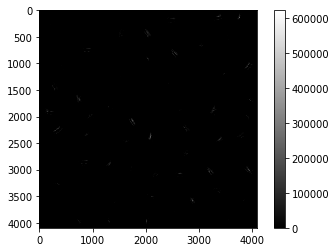

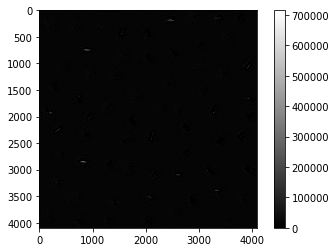

In [89]:
a, b, c = z.shape

for n in range(a):
    plt.figure()
    plt.imshow(z1[n,:,:])
    plt.colorbar()
